### Single Annotated 1D example of `DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from util import (
    print_model_parameters,
    gp_sampler,
    get_torch_size_string,
    plot_1xN_torch_traj_tensor,
    periodic_step,
    plot_ddpm_1d_result,
)
from dataset_sa import get_1d_training_data
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNetLegacy,
    forward_sample,
    eval_ddpm_1d,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[1.12.0+cu113].


### Initialize

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
device = 'cuda:0' # mps, cpu
print ("device:[%s]"%(device))
# for k_idx,key in enumerate(dc.keys()): print ("[%2d] key:[%s]"%(k_idx,key))
# plot_ddpm_constants(dc)

device:[cuda:0]


### Training data `x_0`: [N x C x L]
where N is the number of data, C is the channel size, and L is the length of trajectories

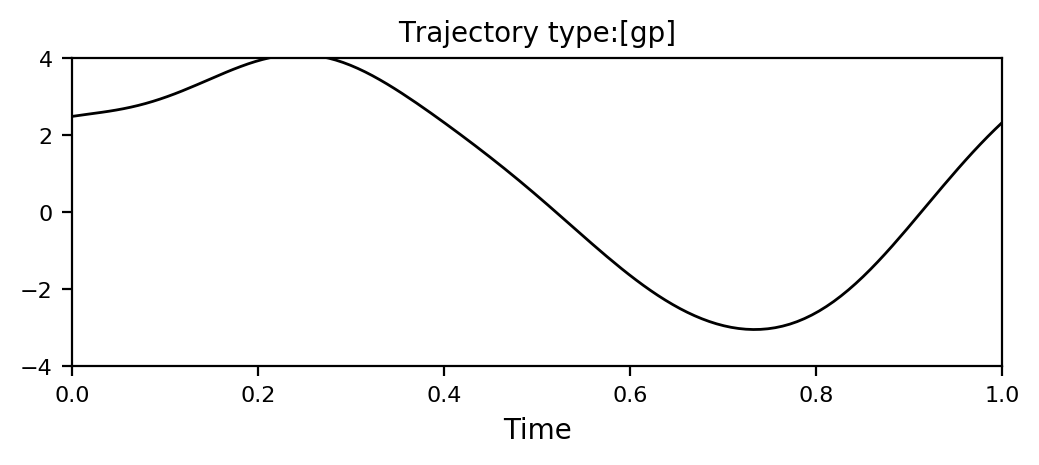

x_0:[1x1x128]


torch.Size([4, 1, 32])

In [3]:
times,x_0, hyp_lens, traj_split, label_split = get_1d_training_data(
    traj_type = 'gp', # gp / step / step2
    n_traj    = 1,
    L         = 128,
    device    = device,
    seed      = 0,
    plot_data = True,
    verbose   = True,
    split = 4, 
    ) # [N x 1 x 128]

traj_split = traj_split.unsqueeze(1)
traj_split.shape

### Train with `U-net lagacy`

In [4]:
idx

NameError: name 'idx' is not defined

In [5]:
# Instantiate U-net
model = DiffusionUNetLegacy(
    name                 = 'unet',
    dims                 = 1,
    n_in_channels        = 1,
    n_base_channels      = 64,
    n_emb_dim            = 128,
    n_cond_dim           = 32,
    n_enc_blocks         = 4, # number of encoder blocks
    n_dec_blocks         = 4, # number of decoder blocks
    n_groups             = 16, # group norm paramter
    n_heads              = 4, # number of heads in QKV attention
    actv                 = nn.SiLU(),
    kernel_size          = 3, # kernel size (3)
    padding              = 1, # padding size (1)
    use_attention        = False,
    skip_connection      = True, # additional skip connection
    chnnel_multiples     = (1,2,4,8),
    updown_rates         = (1,2,2,2),
    use_scale_shift_norm = True,
    device               = device,
) # input:[B x C x L] => output:[B x C x L]

# Configuration
max_iter    = int(1e4)
batch_size  = 128
print_every = 1e3
eval_every  = 2e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=0.0)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.99998)
for it in range(max_iter):
    # Zero gradient
    optm.zero_grad()
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = traj_split[idx,:,:] # [B x C x L]
    cond_batch = label_split[idx,:].float()
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc) # [B x C x L]
    # Noise prediction
    noise_pred,_ = model(x_t_batch,step_batch,cond_batch) # [B x C x L]
    # Compute error
    loss = F.smooth_l1_loss(noise,noise_pred,beta=0.1)
    # Update
    loss.backward()
    optm.step()
    schd.step()
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d][%.1f]%% loss:[%.4f]"%(it,100*it/max_iter,loss.item()))
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 20
        step_list_to_append = np.linspace(0,999,10).astype(np.int64) # save 10 x_ts
        x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device)
        plot_ddpm_1d_result(
            times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
            plot_ancestral_sampling=True,plot_one_sample=False,
            lw_gt=2,lw_sample=1/2,lc_gt=(0,1,0,0.3),lc_sample='k',
            ls_gt='-',ls_sample='--',ylim=(-4,+4),figsize=(5,3))
print ("Training done.")

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
it:[      0][0.0]% loss:[3.7142]
None


TypeError: linear(): argument 'input' (position 1) must be Tensor, not NoneType

In [1]:
x_0.shape

NameError: name 'x_0' is not defined

In [ ]:
# Evaluate
n_sample = 100
step_list_to_append = np.linspace(0,999,10).astype(np.int64)
[0]*
x_t_list = eval_ddpm_1d(model,dc,n_sample,x_0,step_list_to_append,device, cond=)
print ("Sampling [%d] trajectories done."%(n_sample))
for _ in range(10):
    plot_ddpm_1d_result(
        times=times,x_data=x_0,step_list=step_list_to_append,x_t_list=x_t_list,
        plot_ancestral_sampling=False,plot_one_sample=True,
        lw_gt=2,lw_sample=1/2,lc_gt=(0,1,0,0.3),lc_sample='k',
        ls_gt='-',ls_sample='--',ylim=(-4,+4),figsize=(5,3))